<a href="https://colab.research.google.com/github/AZoyaV/Python/blob/main/Sales_dynamics_analysis_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Підключення до бази даних в Google BigQuery (DA dataset)

!pip install --upgrade pandas-gbq google-cloud-bigquery
import pandas as pd
from google.colab import auth
auth.authenticate_user()

project = "data-analytics-mate"

In [ ]:
# Створення датасету, який містить такі поля: дата замовлення, ідентифікатор сесії, континент, країна, девайс, браузер, назва моделі пристрою, операційна система, мова браузера, інформація про джерело трафіку
# канал трафіку, ідентифікатор зареєстрованого користувача, чи підтвердив користувач свій email, чи підписався користувач на розсилку, категорія товару, назва товару, ціна, короткий опис товару

# SQL-запит
query = """
SELECT
  s.date AS Order_date,
  s.ga_session_id AS Session_Id,
  sp.continent AS Continent,
  sp.country AS Country,
  sp.device AS Device,
  sp.browser AS Browser,
  sp.mobile_model_name AS Device_Model,
  sp.operating_system AS Operating_System,
  sp.language AS Browser_Language,
  sp.name AS Traffic_Source,
  sp.channel AS Traffic_Channel,
  a.id AS Registered_User_Id,
  a.is_verified AS Account_Verified,
  a.is_unsubscribed AS Account_Unsubscribed,
  p.category AS Category_Product,
  p.name AS Product_Name,
  p.price AS Price,
  p.short_description AS Product_Description
FROM
  `data-analytics-mate.DA.session` s
LEFT JOIN
  `data-analytics-mate.DA.session_params` sp
ON
  s.ga_session_id = sp.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account_session` acs
ON
  s.ga_session_id = acs.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account` a
ON
  acs.account_id = a.id
LEFT JOIN
  `data-analytics-mate.DA.order` o
ON
  acs.ga_session_id = o.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.product` p
ON
  o.item_id = p.item_id
ORDER BY s.date
"""

data= pd.read_gbq(query, project_id=project)
data.head()

/tmp/ipython-input-1347232219.py:50: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  data= pd.read_gbq(query, project_id=project)


,Order_date,Session_Id,Continent,Country,Device,Browser,Device_Model,Operating_System,Browser_Language,Traffic_Source,Traffic_Channel,Registered_User_Id,Account_Verified,Account_Unsubscribed,Category_Product,Product_Name,Price,Product_Description
0,2020-11-01,65223751,Americas,United States,mobile,Chrome,<Other>,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
# Загальна інформація
print("Кількість колонок:", data.shape[1])

# Кількість унікальних сесій
if "Session_Id" in data.columns:
    unique_sessions = data['Session_Id'].nunique()
    print("Кількість унікальних сесій:", unique_sessions)

# Кількість унікальних акаунтів
if "Registered_User_Id" in data.columns:
    unique_account = data['Registered_User_Id'].nunique()
    print("Кількість унікальних акаунтів:", unique_account)

Кількість колонок: 18
Кількість унікальних сесій: 349545
Кількість унікальних акаунтів: 27945


In [ ]:
print("Період часу, за яким розглядається проект:")
print("Від:", data['Order_date'].min())
print("До :", data['Order_date'].max())

Період часу, за яким розглядається проект:
Від: 2020-11-01 00:00:00
До : 2021-01-31 00:00:00


In [ ]:
# Корегування типу на datetime
data["Order_date"] = pd.to_datetime(data["Order_date"], errors="coerce")

# Визначення типів колонок
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
datetime_cols = data.select_dtypes(include=["datetime64[ns]"]).columns.tolist()

print("\n Кількість числових колонок:", len(numeric_cols))
print("   ", numeric_cols)

print("\n Кількість категоріальних колонок:", len(categorical_cols))
print("   ", categorical_cols)

print("\n Кількість колонок типу datetime:", len(datetime_cols))
print("   ", datetime_cols)


 Кількість числових колонок: 5
    ['Session_Id', 'Registered_User_Id', 'Account_Verified', 'Account_Unsubscribed', 'Price']

 Кількість категоріальних колонок: 12
    ['Continent', 'Country', 'Device', 'Browser', 'Device_Model', 'Operating_System', 'Browser_Language', 'Traffic_Source', 'Traffic_Channel', 'Category_Product', 'Product_Name', 'Product_Description']

 Кількість колонок типу datetime: 1
    ['Order_date']


In [ ]:
# Аналіз пропущених значень
missing = data.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Колонки з пропущеними значеннями:")
print(missing)

Колонки з пропущеними значеннями:
Product_Description     346764
Price                   346764
Product_Name            346764
Category_Product        346764
Account_Verified        321600
Account_Unsubscribed    321600
Registered_User_Id      321600
Browser_Language        114266
dtype: int64


## Можливі причини відсутності даних:
- технічні пропуски;
- користувач не зареєстрований;
- немає інформації про верифікацію;
- немає даних про підписку;
- відсутність товару у замовленні;
- не всі сесії закінчилися замовленням;
- анонімні користувачі;
- не підтверджена локалізація користувача (заходив з іншого девайсу).

In [ ]:
# Видалення пропусків у колонці Price
price_clean = data.dropna(subset=["Price"])

# Статистичні показники по колонці Price без пропусків
print("Статистичні дані по ціні (з урахуванням пропущених значень):")
display(price_clean["Price"].describe().round(2))

Статистичні дані по ціні (з урахуванням пропущених значень):


,Price
count,2781.00
mean,928.63
std,1319.68
min,3.00
25%,150.00
50%,399.00
75%,1140.00
max,8900.00


In [ ]:
print("Кількість унікальних значень у категоріальних колонках:")
category_summary = data[categorical_cols].nunique().sort_values(ascending=False)
print(category_summary)

Кількість унікальних значень у категоріальних колонках:
Product_Description    1064
Product_Name            449
Country                 108
Category_Product         14
Device_Model             10
Browser_Language          9
Continent                 6
Browser                   6
Operating_System          6
Traffic_Source            5
Traffic_Channel           5
Device                    3
dtype: int64


In [ ]:
# Топ-3 континенти та Топ-5 країн, що мають найбільші продажі та найбільшу кількість замовлень
continent_sales = price_clean.groupby("Continent")["Price"].sum().sort_values(ascending=False)
continent_orders = data.groupby("Continent")["Order_date"].count().sort_values(ascending=False)

print("Топ-3 континенти за найбільшими продажами:")
display(continent_sales.head(3))
print("\n")
print("Топ-3 континенти за найбільшою кількістю замовлень:")
display(continent_orders.head(3))

country_sales = price_clean.groupby("Country")["Price"].sum().sort_values(ascending=False)
country_orders = data.groupby("Country")["Order_date"].count().sort_values(ascending=False)

print("Топ-5 країн за найбільшими продажами:")
display(country_sales.head(5))
print("\n")
print("Топ-5 країн за найбільшою кількістю замовлень:")
display(country_orders.head(5))

Топ-3 континенти за найбільшими продажами:


,Price
Continent,
Americas,1417579.6
Asia,619065.0
Europe,492709.8




Топ-3 континенти за найбільшою кількістю замовлень:


,Order_date
Continent,
Americas,193179
Asia,83113
Europe,65135


Топ-5 країн за найбільшими продажами:


,Price
Country,
United States,1100367.8
India,207605.5
Canada,192894.4
Singapore,65691.8
United Kingdom,65141.5




Топ-5 країн за найбільшою кількістю замовлень:


,Order_date
Country,
United States,153470
India,32763
Canada,25994
United Kingdom,11003
France,6958


/tmp/ipython-input-2405689996.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_continents_sales.index, y=top_continents_sales.values, ax=axes[0,0], palette="Blues_d")
/tmp/ipython-input-2405689996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_continents_orders.index, y=top_continents_orders.values, ax=axes[0,1], palette="Greens_d")
/tmp/ipython-input-2405689996.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries_sales.index, y=top_countries_sales.values, ax=axes[1,0], palette="Blues_d")
/tmp/ipython-in

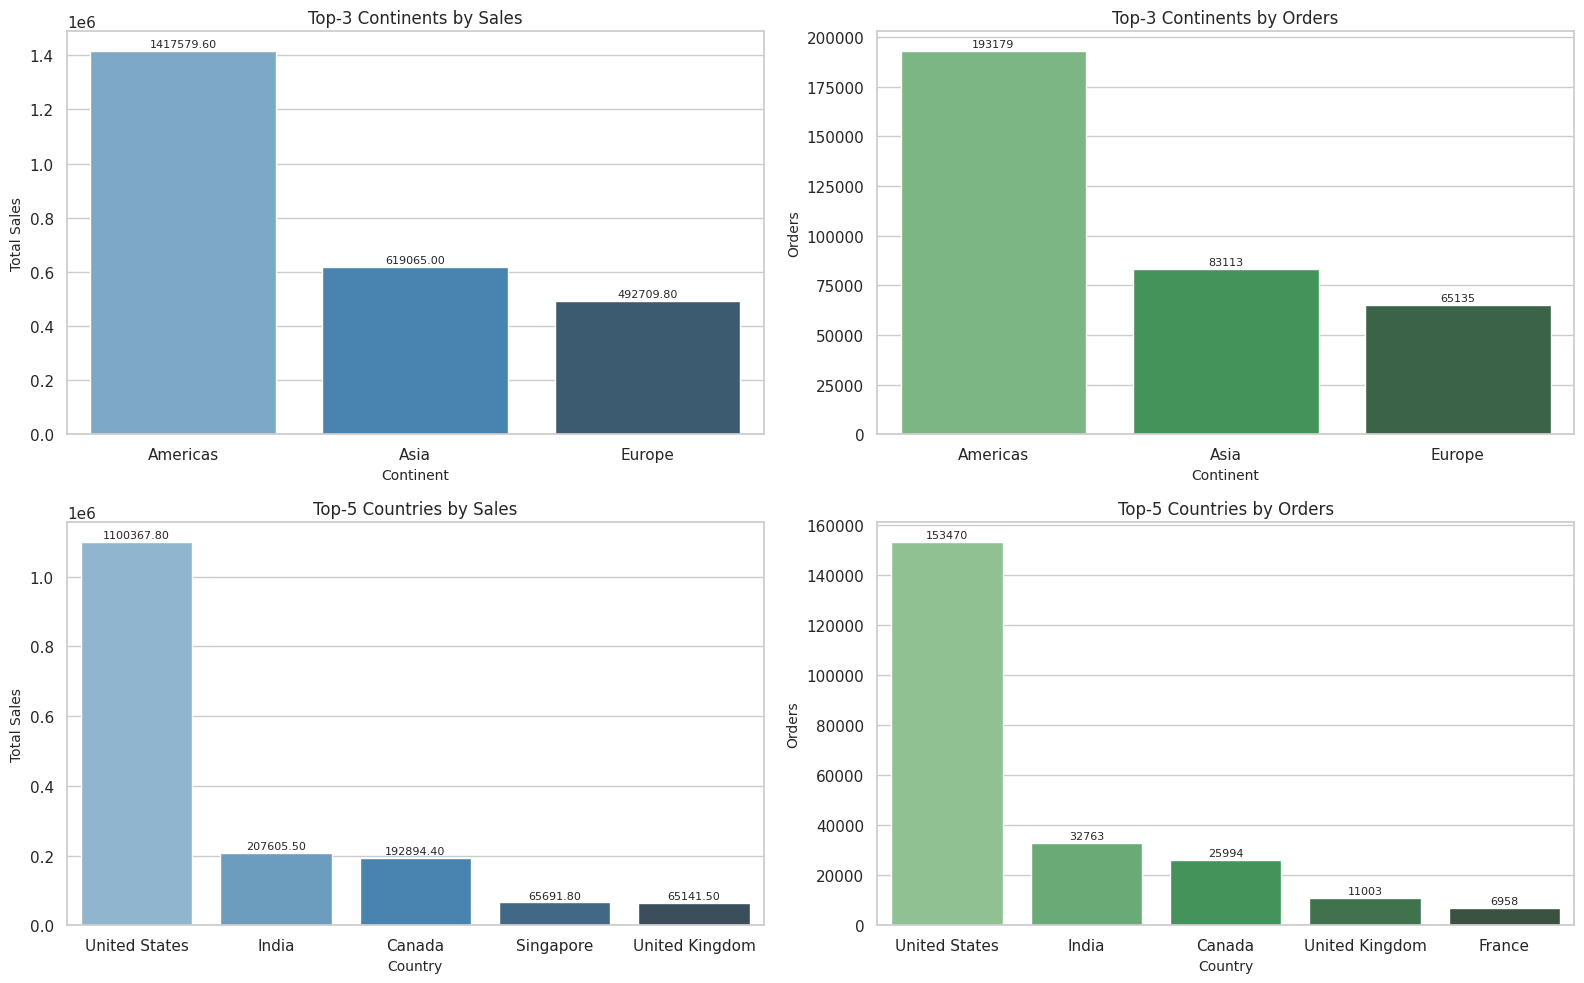

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Стиль графіків
sns.set(style="whitegrid")

# Фігура з 4 графіками (2 рядки x 2 колонки)
fig, axes = plt.subplots(2, 2, figsize=(16,10))

# Графік 1: Топ-3 континенти за продажами
top_continents_sales = continent_sales.head(3)
sns.barplot(x=top_continents_sales.index, y=top_continents_sales.values, ax=axes[0,0], palette="Blues_d")
axes[0,0].set_title("Top-3 Continents by Sales", fontsize=12)
axes[0,0].set_xlabel("Continent", fontsize=10)
axes[0,0].set_ylabel("Total Sales", fontsize=10)
for i, v in enumerate(top_continents_sales.values):
    axes[0,0].text(i, v + max(top_continents_sales.values)*0.01, f"{v:.2f}", ha="center", fontsize=8)

# Графік 2: Топ-3 континенти за замовленнями
top_continents_orders = continent_orders.head(3)
sns.barplot(x=top_continents_orders.index, y=top_continents_orders.values, ax=axes[0,1], palette="Greens_d")
axes[0,1].set_title("Top-3 Continents by Orders", fontsize=12)
axes[0,1].set_xlabel("Continent", fontsize=10)
axes[0,1].set_ylabel("Orders", fontsize=10)
for i, v in enumerate(top_continents_orders.values):
    axes[0,1].text(i, v + max(top_continents_orders.values)*0.01, f"{v}", ha="center", fontsize=8)

# Графік 3: Топ-5 країн за продажами
top_countries_sales = country_sales.head(5)
sns.barplot(x=top_countries_sales.index, y=top_countries_sales.values, ax=axes[1,0], palette="Blues_d")
axes[1,0].set_title("Top-5 Countries by Sales", fontsize=12)
axes[1,0].set_xlabel("Country", fontsize=10)
axes[1,0].set_ylabel("Total Sales", fontsize=10)
for i, v in enumerate(top_countries_sales.values):
    axes[1,0].text(i, v + max(top_countries_sales.values)*0.01, f"{v:.2f}", ha="center", fontsize=8)

# Графік 4: Топ-5 країн за замовленнями
top_countries_orders = country_orders.head(5)
sns.barplot(x=top_countries_orders.index, y=top_countries_orders.values, ax=axes[1,1], palette="Greens_d")
axes[1,1].set_title("Top-5 Countries by Orders", fontsize=12)
axes[1,1].set_xlabel("Country", fontsize=10)
axes[1,1].set_ylabel("Orders", fontsize=10)
for i, v in enumerate(top_countries_orders.values):
    axes[1,1].text(i, v + max(top_countries_orders.values)*0.01, f"{v}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

## За континентами динаміка продажів і замовлень є однаковою: перше місце посідають Америка, далі - Азія, а третє - Європа.
## Що ж стосується країн, то лідерами за обома показниками є США, Індія та Канада (перші три місця). На четвертому й п’ятому місцях спостерігається розбіжність: за обсягом продажів до трійки лідерів наближаються Сінгапур і Великобританія, тоді як за кількістю замовлень — Великобританія та Франція.

In [ ]:
#Топ-10 категорій товарів за загальною сумою продажів
category_total_sales = price_clean.groupby("Category_Product")["Price"].sum().sort_values(ascending=False)
print("Топ-10 категорій товарів за сумою продажів:")
display(category_total_sales.head(10))

#Топ-10 категорій товарів у країні з найбільшими продажами

# Визначаємо країну з найбільшими продажами
top_country_sales = country_sales.idxmax()

#Групуємо дані за категоріями товарів у цій країні
category_top_country_sales = price_clean[price_clean["Country"]==top_country_sales].groupby("Category_Product")["Price"].sum().sort_values(ascending=False)
print(f"Топ-10 категорій товарів у країні з найбільшими продажами ({top_country_sales}):")
display(category_top_country_sales.head(10))

Топ-10 категорій товарів за сумою продажів:


,Price
Category_Product,
Sofas & armchairs,660456.0
Chairs,539956.2
Beds,394705.0
Bookcases & shelving units,275509.6
Cabinets & cupboards,215869.5
Tables & desks,153533.0
Outdoor furniture,143694.2
Chests of drawers & drawer units,57988.0
Bar furniture,51014.0


Топ-10 категорій товарів у країні з найбільшими продажами (United States):


,Price
Category_Product,
Sofas & armchairs,301810.5
Chairs,217604.4
Beds,159607.5
Bookcases & shelving units,104166.9
Cabinets & cupboards,86776.5
Tables & desks,81323.5
Outdoor furniture,59765.0
Bar furniture,26343.0
Children's furniture,24092.0


/tmp/ipython-input-2943721127.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top10_global.index, x=top10_global.values, ax=axes[0], palette="Blues_d")
/tmp/ipython-input-2943721127.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top10_country.index, x=top10_country.values, ax=axes[1], palette="Greens_d")


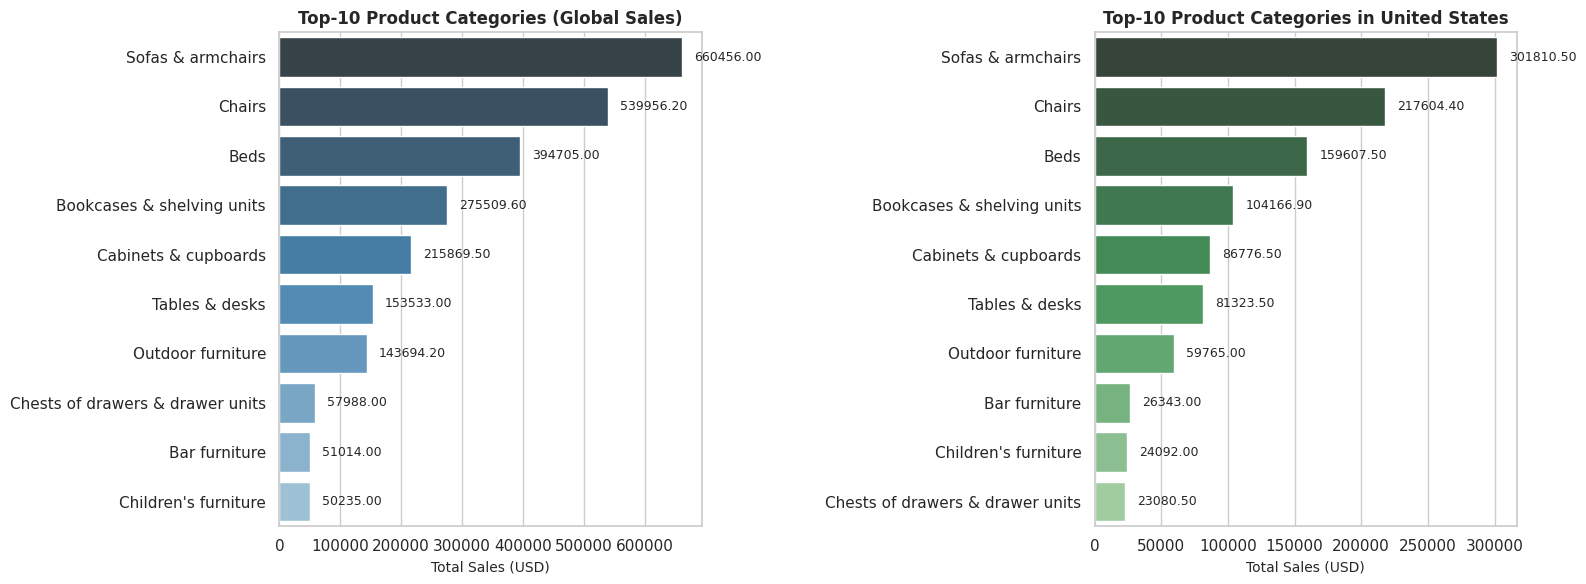

In [ ]:
# Стиль графіків
sns.set(style="whitegrid")

# Фігура з 2 графіками (1 рядоу x 2 колонки)
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Графік 1: Global
top10_global = category_total_sales.head(10).sort_values()
sns.barplot(y=top10_global.index, x=top10_global.values, ax=axes[0], palette="Blues_d")
axes[0].set_title("Top-10 Product Categories (Global Sales)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Total Sales (USD)", fontsize=10)
axes[0].set_ylabel("")
for i, v in enumerate(top10_global.values):
    axes[0].text(v + max(top10_global.values)*0.03, i, f"{v:.2f}", va="center", fontsize=9)

axes[0].invert_yaxis()

# Графік 2: Country
top10_country = category_top_country_sales.head(10).sort_values()
sns.barplot(y=top10_country.index, x=top10_country.values, ax=axes[1], palette="Greens_d")
axes[1].set_title(f"Top-10 Product Categories in {top_country_sales}", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Total Sales (USD)", fontsize=10)
axes[1].set_ylabel("")
for i, v in enumerate(top10_country.values):
    axes[1].text(v + max(top10_country.values)*0.03, i, f"{v:.2f}", va="center", fontsize=9)

axes[1].invert_yaxis()

# Оформлення
plt.tight_layout(w_pad=4)
plt.show()

## Зважаючи на отримані результати, можна побачити, що на глобальному рівні та для країни з найвищими продажами (США) динаміка даних загалом схожа. Лише останні три позиції демонструють змішане розташування, що, ймовірно, відображає специфіку цієї країни та індивідуальні вподобання її покупців.

In [ ]:
# Аналіз продажів у розрізі типів та моделей девайсів (у % від загальних продажів)

# Типи
types_device_sales = price_clean.groupby("Device")["Price"].sum()
types_device_sales_percent = (types_device_sales / types_device_sales.sum() * 100).sort_values(ascending=False).round(2)
print("Продажі за типами девайсів (%):")
display(types_device_sales_percent)

# Моделі
model_device_sales = price_clean.groupby("Device_Model")["Price"].sum()
model_device_sales_percent = (model_device_sales / model_device_sales.sum() * 100).sort_values(ascending=False).round(2)
print("Продажі за моделями девайсів (%):")
display(model_device_sales_percent)

Продажі за типами девайсів (%):


,Price
Device,
desktop,57.35
mobile,40.25
tablet,2.40


Продажі за моделями девайсів (%):


,Price
Device_Model,
Chrome,28.73
iPhone,21.64
<Other>,20.24
Safari,19.29
ChromeBook,4.84
Edge,1.91
iPad,1.57
Firefox,1.13
Pixel 4 XL,0.35


/tmp/ipython-input-1544449716.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=types_device_sales_percent.index, x=types_device_sales_percent.values, ax=axes[0], palette="Blues_d")
/tmp/ipython-input-1544449716.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=model_device_sales_percent.index, x=model_device_sales_percent.values, ax=axes[1], palette="Greens_d")


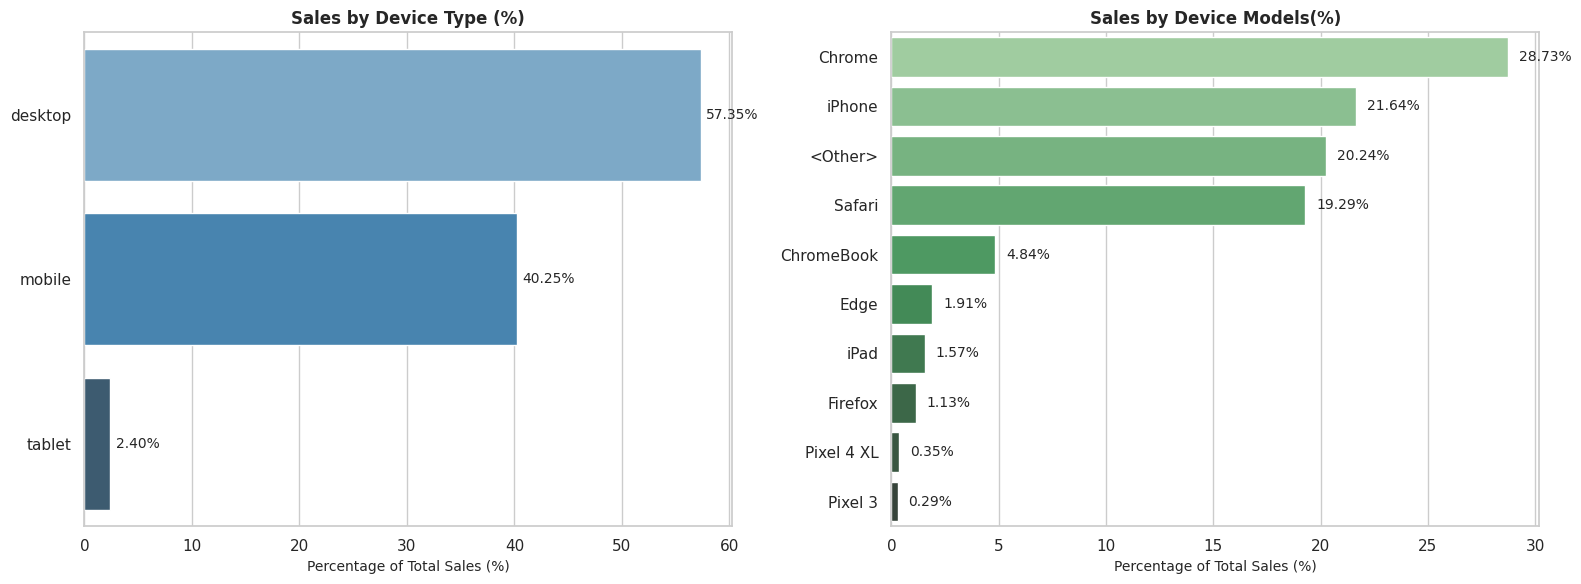

In [ ]:
# Фігура з 2 графіками (1 ряд x 2 колонки)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік 1: Типи девайсів
sns.barplot(y=types_device_sales_percent.index, x=types_device_sales_percent.values, ax=axes[0], palette="Blues_d")
axes[0].set_title("Sales by Device Type (%)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Percentage of Total Sales (%)", fontsize=10)
axes[0].set_ylabel("")
for i, v in enumerate(types_device_sales_percent.values):
    axes[0].text(v + 0.5, i, f"{v:.2f}%", va='center', fontsize=10)

# Графік 2: Топ-10 моделей девайсів
sns.barplot(y=model_device_sales_percent.index, x=model_device_sales_percent.values, ax=axes[1], palette="Greens_d")
axes[1].set_title("Sales by Device Models(%)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Percentage of Total Sales (%)", fontsize=10)
axes[1].set_ylabel("")
for i, v in enumerate(model_device_sales_percent.values):
    axes[1].text(v + 0.5, i, f"{v:.2f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## За типами пристроїв перше місце займає desktop (57,35%), далі йде mobile (40,25%), а останнє - tablet (2,40%).
## Що стосується моделей, лідирують Chrome (28,73%) та iPhone (21,64%). На третьому місці знаходяться інші моделі (20,24%), а останнє місце посідає Pixel 3 (0,29%).

In [ ]:
# Аналіз продажів за джерелами трафіку (у % від загальних продажів)
traffic_sales = price_clean.groupby("Traffic_Source")["Price"].sum()
traffic_sales_percent = (traffic_sales / traffic_sales.sum() * 100).sort_values(ascending=False).round(2)
print("Продажі за джерелами трафіку (%):")
display(traffic_sales_percent.head())

Продажі за джерелами трафіку (%):


,Price
Traffic_Source,
(organic),36.19
(direct),23.58
(referral),16.40
<Other>,16.40
(data deleted),7.43


## Найбільшу частку продажів забезпечує органічний трафік (36,19%), що свідчить про ефективність SEO. Прямі відвідування (23,58%) також формують значну частку. Трафік з реферальних джерел і інших каналів має приблизно однакову частку (по 16,40%), тоді як продажі з видалених або анонімних даних складають незначну частку (7,43%). Загалом, для подальшого зростання продажів доцільно посилювати органічні та прямі канали трафіку.

# Аналіз динаміки продажів

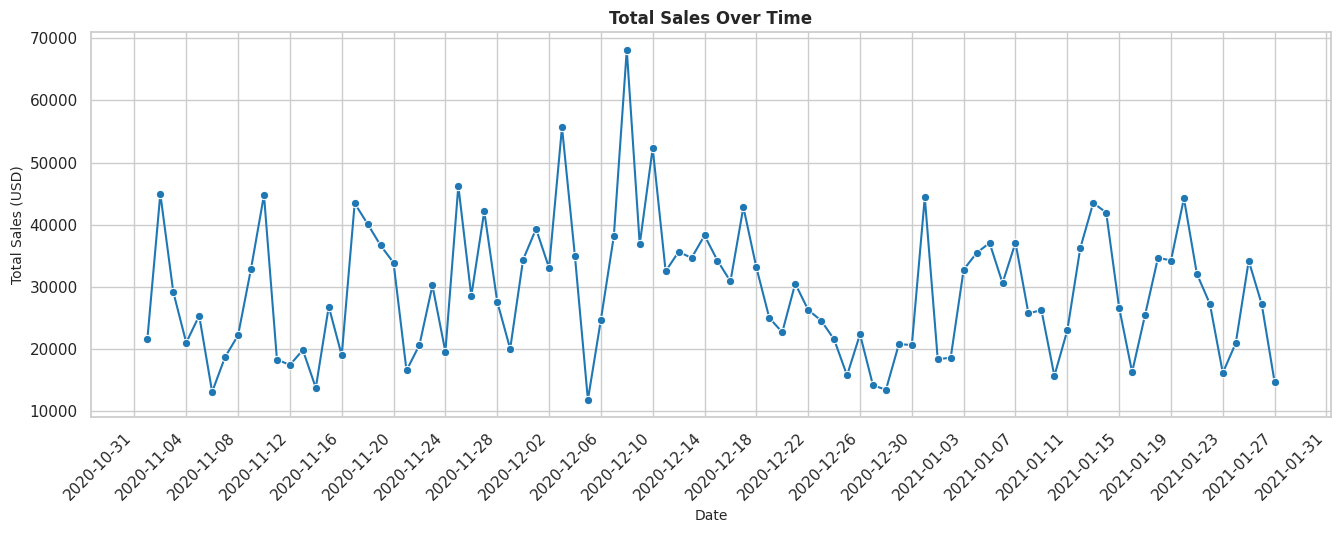

In [ ]:
import matplotlib.dates as mdates

# Аналіз загальних продажів за кожну дату
daily_sales = price_clean.groupby("Order_date")["Price"].sum().reset_index()

plt.figure(figsize=(16,5))

sns.lineplot(data=daily_sales, x="Order_date", y="Price", marker="o", color="#1f77b4")
plt.title("Total Sales Over Time", fontsize=12, fontweight="bold")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Total Sales (USD)", fontsize=10)

# Відображаємо кожну 4-у дату
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.show()

## Аналіз графіка показує, що загальні продажі протягом періоду мають помітні коливання:
- Спостерігаються регулярні сезонні стрибки продажів, які можуть відповідати святковим періодам або маркетинговим кампаніям (наприклад: у грудні, що може бути пов'язано з новорічними святами та продажам у вихідний день).
- Між піками продажі знижуються до відносно низького рівня (близько 12–20 тис. USD), що свідчить про нестабільний попит у звичайні дні.
- Найвищий показник продажів сягає майже 70 тис. USD, що вказує на ефективність певних акцій
- Після різдвяно-новорічних свят спостерігаються коливання у продажах до середніх значень (20–35 тис. USD).
- Важливим є планування запасів і маркетингових активностей в святкові дні.

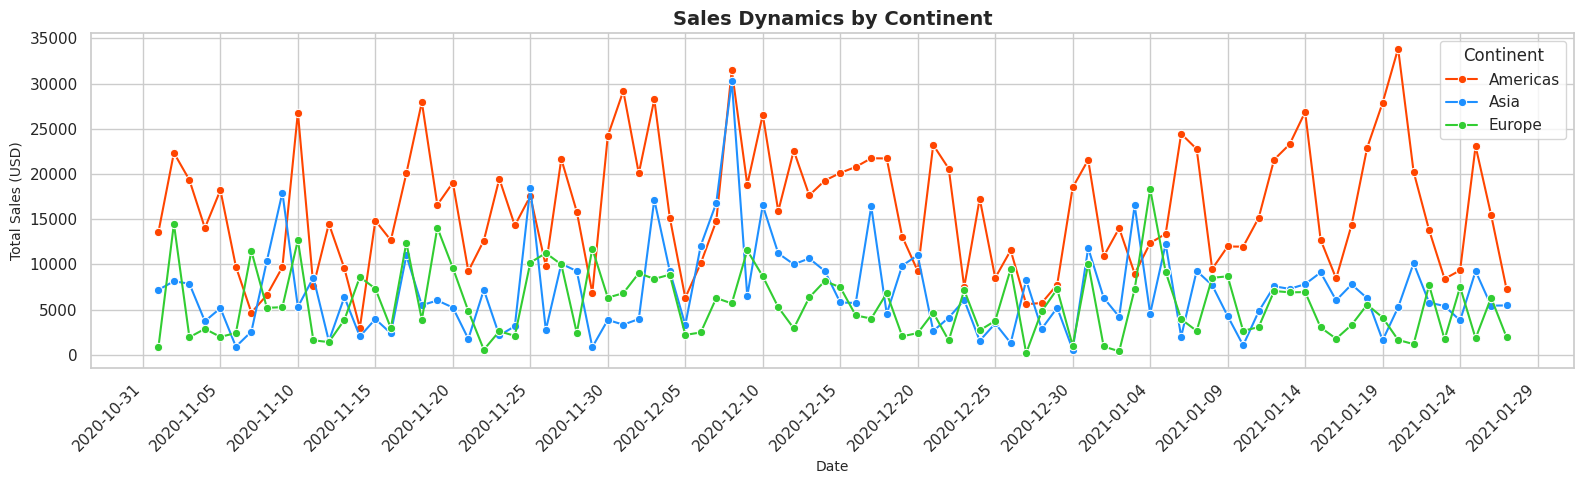

In [ ]:
# Динаміка продажів за континентами (Америка, Азія, Європа)

continent_sales = price_clean[price_clean["Continent"].isin(["Americas","Asia","Europe"])]
continent_daily = continent_sales.groupby(["Order_date","Continent"])["Price"].sum().reset_index()

plt.figure(figsize=(16,5))

sns.lineplot(data=continent_daily, x="Order_date", y="Price", hue="Continent", marker="o", palette=["#FF4500","#1E90FF","#32CD32"])
plt.title("Sales Dynamics by Continent", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Total Sales (USD)", fontsize=10)

# Відображаємо кожну 5-ю дату
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.legend(title="Continent")
plt.tight_layout()
plt.show()

## Аналіз динаміки продажів за континентами показує, що поведінка ринку суттєво відрізняється: для Америки характерні піки продажів у святкові дні, що свідчить про високу сезонну залежність (до 35 тис. USD).
## В Азії продажі зростають перед новорічними святами, а після них помітно знижуються, що також вказує на сезонний ефект.
##Європейський ринок демонструє відносно стабільну динаміку протягом усього періоду, з незначними коливаннями, при цьому максимальні продажі припадають на перші дні вже нового року (до 20 тис. USD).

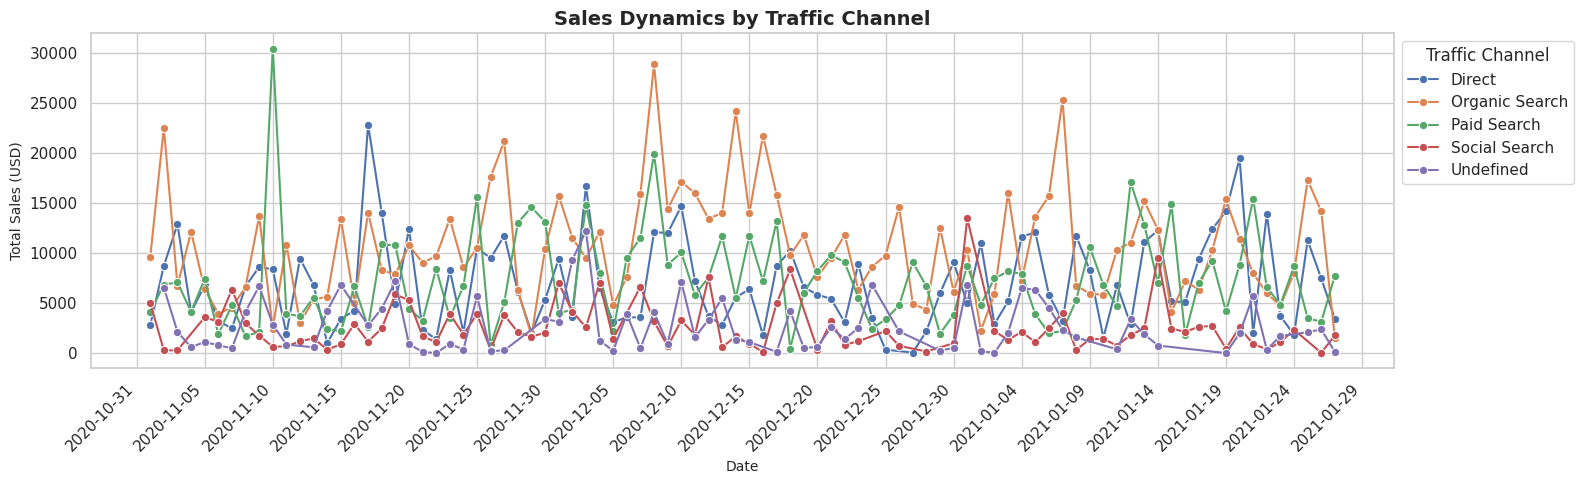

In [ ]:
# Динаміка продажів за каналами трафіку
channel_daily = price_clean.groupby(["Order_date","Traffic_Channel"])["Price"].sum().reset_index()

plt.figure(figsize=(16,5))

sns.lineplot(data=channel_daily, x="Order_date", y="Price", hue="Traffic_Channel", marker="o")
plt.title("Sales Dynamics by Traffic Channel", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Total Sales (USD)", fontsize=10)

# Відображаємо кожну 5-ю дату
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.legend(title="Traffic Channel", bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()

## Аналіз динаміки продажів за каналами трафіку показує, що найбільші обсяги продажів спостерігаються через Paid Search, Direct та Organic Search. Їх піки коливаються в межах від 20 тис. до 32 тис. USD., що вказує на високу ефективність цих каналів у залученні покупців та генерації продажів.
## Канали Social Search та Undefined демонструють більш стабільну динаміку продажів з меншими коливаннями. У Social Search спостерігається невеликий пік відразу після нового року, а у Undefined - напередодні новорічних свят, де максимальні значення не перевищують 12 тис. USD.
## Таким чином, можна сказати, що основні продажі зосереджені в високоефективних каналах, тоді як інші канали забезпечують стабільність і підтримують додатковий обсяг продажів у певні святкові періоди.

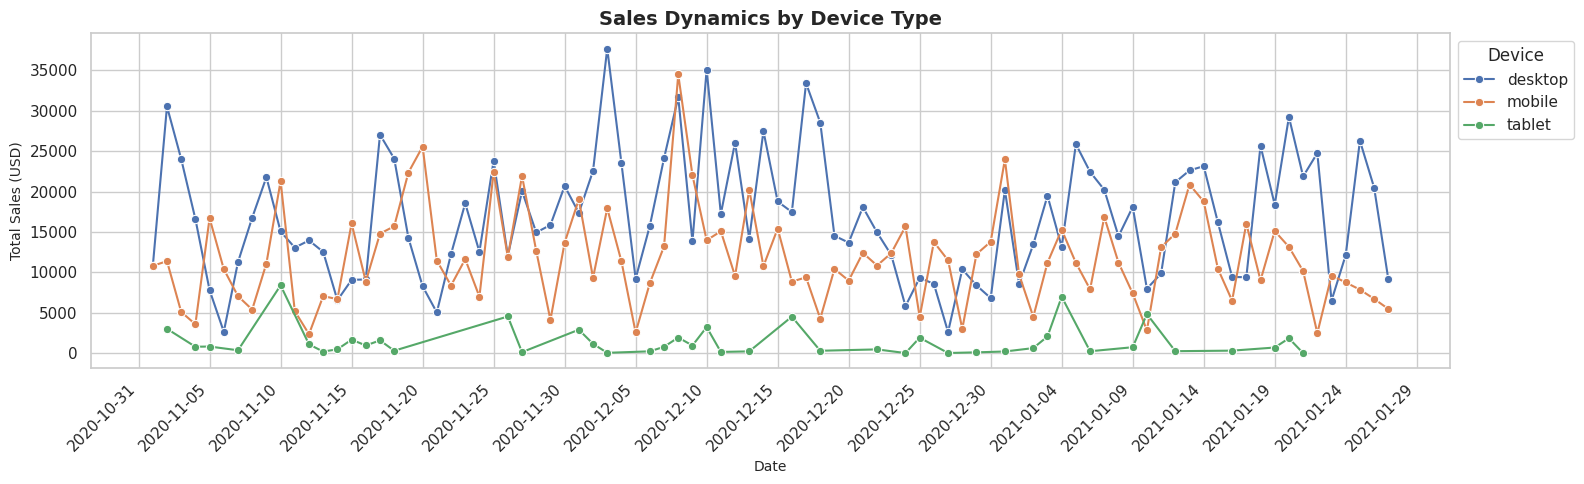

In [ ]:
# Динаміка продажів за типами девайсів
device_daily = price_clean.groupby(["Order_date","Device"])["Price"].sum().reset_index()

plt.figure(figsize=(16,5))

sns.lineplot(data=device_daily, x="Order_date", y="Price", hue="Device", marker="o")
plt.title("Sales Dynamics by Device Type", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Total Sales (USD)", fontsize=10)

# Відображаємо кожну 5-ю дату
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.legend(title="Device", bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()

## Аналіз продажів за типами девайсів показав, що найефективнішим є desktop. Проте для нього характерні різкі пікові коливання продажів, що вказує на високу залежність від певних подій (за нашими спостереженями: святкові дні), коли користувачі активно здійснюють покупки.
## Mobile також демонструє помітні сезонні коливання, проте вони відбуваються у інші часові періоди, що вказує на різний патерн поведінки користувачів порівняно з desktop.
## Tablet має найнижчі показники продажів серед усіх типів девайсів, що свідчить про його обмежену ефективність для комерційних цілей. Використання цього каналу у маркетингових стратегіях потребує перегляду.

# Зведені таблиці

In [ ]:
# Кількість сесій за каналами трафіку та типами девайсів

# Копіюємо дані
session_clean = data.copy()

# Замінюємо технічні значення на NaN
session_clean["Traffic_Channel"] = session_clean["Traffic_Channel"].replace(
    ["Undefined", "undefined", "None", "not set", ""], pd.NA
)
session_clean["Device"] = session_clean["Device"].replace(
    ["Undefined", "undefined", "None", "not set", ""], pd.NA
)

# Видаляємо рядки з пропущеними значеннями
sessions_clean = session_clean.dropna(subset=["Traffic_Channel", "Device"])

# Зведена таблиця: кількість сесій
pivot_sessions = sessions_clean.pivot_table(
    index="Traffic_Channel",
    columns="Device",
    values="Session_Id",
    aggfunc="nunique",
    fill_value=0
)
print("Кількість сесій за каналами трафіку та типами девайсів:")
display(pivot_sessions.style.background_gradient(cmap="YlOrRd"))

Кількість сесій за каналами трафіку та типами девайсів:


Device,desktop,mobile,tablet
Traffic_Channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638


## Результати:
- Аналіз кількості сесій чітко показує домінування двох основних каналів: Organic Search та Paid Search. За ним слідує Direct. На противагу цьому, Social Search є найменшим джерелом трафіку, забезпечуючи лише близько 27914 сесій, що в 4-5 разів менше, ніж Organic Search.
- Незалежно від каналу трафіку, desktop пристрої є основним джерелом сесій. У кожному з чотирьох каналів кількість сесій, що надходять із desktop, значно перевищує трафік, отриманий з інших типів пристроїв. Mobile пристрої займають стабільне друге місце, генеруючи приблизно 60-70% від кількості desktop-сесій у кожному каналі (наприклад, 49014 mobile-сесій проти 72622 desktop-сесій для Organic Search).
- Tablet пристрої генерують найменшу частку трафіку, в середньому лише 2-3% від загальної кількості сесій.
##Дані свідчать про те, що для максимального збільшення кількості сесій найбільшу увагу слід приділяти оптимізації та інвестиціям у канал Organic Search, оскільки він є найбільш продуктивним. Одночасно необхідно підтримувати високу ефективність на desktop пристроях, які є ключовими для всіх каналів. Хоча mobile-трафік значний, домінування desktop свідчить про те, що основна частина користувацької активності, яка призводить до сесій, відбувається саме на великих екранах.

In [ ]:
# Загальні продажі за категоріями товарів (топ-10 категорій) у топ-5 країнах

top_countries_sales = country_sales.head(5).index
top10_categories = category_total_sales.head(10).index

# Фільтруємо дані
top_countries_data = data[
    (data["Country"].isin(top_countries_sales)) &
    (data["Category_Product"].isin(top10_categories))
]

# Зведена таблиця: сумарні продажі
pivot_sales = top_countries_data.pivot_table(
    index="Category_Product",
    columns="Country",
    values="Price",
    aggfunc="sum",
    fill_value=0
)
print("Загальні продажі за топ-10 категоріями у топ-5 країнах:")
display(pivot_sales.style.background_gradient(cmap="YlOrRd").format("{:.2f}"))

Загальні продажі за топ-10 категоріями у топ-5 країнах:


Country,Canada,India,Singapore,United Kingdom,United States
Category_Product,,,,,
Bar furniture,3763.00,503.00,129.00,2561.00,26343.00
Beds,40796.00,20160.00,6939.00,11850.00,159607.50
Bookcases & shelving units,17364.00,29394.40,5078.00,6311.00,104166.90
Cabinets & cupboards,22746.00,17447.00,8750.00,7574.50,86776.50
Chairs,22841.40,49072.20,10810.00,16528.00,217604.40
Chests of drawers & drawer units,3640.00,7922.00,0.00,881.00,23080.50
Children's furniture,3362.00,4601.00,304.00,1135.00,24092.00
Outdoor furniture,1795.00,16364.40,3016.80,1982.00,59765.00
Sofas & armchairs,55946.00,49474.50,28049.00,10578.00,301810.50


## Найбільш дохідні категорії (Глобально):
- Sofas & armchairs (особливо у США та Канаді).
- Chairs (сильний показник у всіх великих країнах).
- Beds (сильний показник у США та Канаді).
- Bookcases & shelving units (сильний показник у США та Індії).

## Найменш дохідні категорії (Глобально):
- Bar furniture, Chests of drawers & drawer units, Children's furniture, Outdoor furniture.

## Сполучені Штати є ключовим ринком, який генерує основний дохід у більшості категорій, а Sofas & armchairs є найбільш дохідною категорією продукту на глобальному рівні.

In [ ]:
# Кількість замовлень за браузерами та типами девайсів

# Видаляємо рядки з пропущеними значеннями
browser_device_clean = data.dropna(subset=["Browser", "Device"])

pivot_browser_device = browser_device_clean.pivot_table(
    index="Browser",
    columns="Device",
    values="Order_date",
    aggfunc="count",
    fill_value=0
)
print("Кількість замовлень за браузерами та типами девайсів:")
display(pivot_browser_device.style.background_gradient(cmap="YlOrRd"))

Кількість замовлень за браузерами та типами девайсів:


Device,desktop,mobile,tablet
Browser,,,
,2313,6000,617
Android Webview,0,4227,218
Chrome,171859,62706,3895
Edge,8016,7,0
Firefox,6063,370,0
Safari,16178,63957,3119


Аналіз кількості замовлень показує явне домінування Chrome як основного  браузера, що генерує продажі, особливо на desktop пристроях (171859 замовлень).
Другим за важливістю браузером є Safari, який, на відміну від Chrome, отримує найбільшу кількість замовлень з mobile пристроїв (63957 замовлень).


---


Замовлення з desktop домінують завдяки Chrome, Edge та Firefox. Замовлення з mobile пристроїв високі завдяки Safari та Chrome. Браузери Edge та Firefox генерують майже весь свій трафік замовлень на desktop пристроях (Edge: 8016 desktop та 7 mobile; Firefox: 6063 desktop та 370 mobile).


---


Tablet пристрої, як і в попередніх аналізах, є найменш значущим джерелом замовлень, хоча Safari та Chrome генерують з них найбільшу частку.

# Статистичний аналіз взаємозв’язків

,Continent,Device,Pearson Corr,Pearson p,Spearman Corr,Spearman p
0,Americas,desktop,0.673,0.000,0.671,0.000
1,Americas,mobile,0.543,0.000,0.524,0.000
2,Americas,tablet,0.183,0.088,0.187,0.081
3,Asia,desktop,0.587,0.000,0.545,0.000
4,Asia,mobile,0.425,0.000,0.283,0.008
5,Asia,tablet,-0.047,0.665,-0.119,0.271
6,Europe,desktop,0.263,0.013,0.295,0.005
7,Europe,mobile,0.387,0.000,0.389,0.000
8,Europe,tablet,0.398,0.000,0.209,0.051


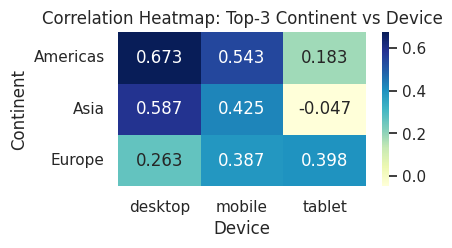

In [ ]:
from scipy.stats import pearsonr, spearmanr
import itertools

# Кореляція продажів між топ-3 континентами і девайсами

# Продажі по континентах
continent_daily_wide = continent_daily.pivot(index="Order_date", columns="Continent", values="Price").fillna(0)

# Продажі по типах девайсів
device_daily_wide = device_daily.pivot(index="Order_date", columns="Device", values="Price").fillna(0)

# Об'єднуємо по даті
combined_daily_1 = continent_daily_wide.join(device_daily_wide, how="outer").fillna(0)

# Кореляційна матриця
corr_combined = combined_daily_1.corr()

# Парні кореляції з p-value
results = []
for continent in continent_daily_wide:
    for device in device_daily_wide.columns:
        pearson_corr, pearson_p = pearsonr(combined_daily_1[continent], combined_daily_1[device])
        spearman_corr, spearman_p = spearmanr(combined_daily_1[continent], combined_daily_1[device])
        results.append({
            "Continent": continent,
            "Device": device,
            "Pearson Corr": round(pearson_corr,3),
            "Pearson p": round(pearson_p,3),
            "Spearman Corr": round(spearman_corr,3),
            "Spearman p": round(spearman_p,3)
        })

corr_table = pd.DataFrame(results)
display(corr_table)

#Heatmap континенти (рядки) × девайси (стовпці)
heatmap_data = corr_table.pivot(index="Continent", columns="Device", values="Pearson Corr")

plt.figure(figsize=(4,2))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Correlation Heatmap: Top-3 Continent vs Device")
plt.show()

## Результати:
- Найсильніші позитивні кореляції між континентом (топ-3) і моделлю девайсу спостерігаються для desktop у всіх регіонах, особливо у Americas (Pearson 0,673, Spearman 0,671).
- Для mobile кореляції теж позитивні, але слабші, ніж для desktop, причому Europe має сильнішу кореляцію (Pearson 0,387).
- Tablet демонструє найслабші та навіть негативні кореляції, особливо у Asia (Pearson -0,047), що свідчить про відсутність або зворотний тренд між продажами на планшетах та континентом.

Статистична значущість:
- У більшості випадків p < 0.05, тобто кореляції статистично значущі.

Винятки: tablet у Americas (Pearson p = 0,088) та tablet у Asia (Pearson p = 0,665), де кореляції незначущі.

Основне:
- Desktop - ключовий девайс для всіх регіонів, особливо в Америці.
- Mobile має помірний вплив на продажі, значущо у Europe та Americas.
- Tablet практично не впливає на продажі у Asia та слабо у інших регіонах.

,Channel,Browser,Pearson Corr,Pearson p,Spearman Corr,Spearman p
0,Direct,Chrome,-0.086,0.416,-0.105,0.321
1,Direct,Edge,-0.086,0.416,-0.105,0.321
2,Direct,Safari,-0.086,0.416,-0.105,0.321
3,Organic Search,Chrome,-0.010,0.921,-0.006,0.955
4,Organic Search,Edge,-0.010,0.921,-0.006,0.955
5,Organic Search,Safari,-0.010,0.921,-0.006,0.955
6,Paid Search,Chrome,-0.061,0.564,-0.069,0.513
7,Paid Search,Edge,-0.061,0.564,-0.069,0.513
8,Paid Search,Safari,-0.061,0.564,-0.069,0.513
9,Social Search,Chrome,0.123,0.242,0.140,0.182


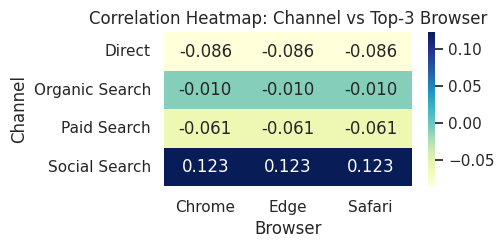

In [ ]:
# Кореляція продажів між каналом трафіку і браузером

# Очистка даних від пустих значень
channel_daily_clean = sessions_clean.groupby(["Order_date","Traffic_Channel"])["Price"].sum().reset_index()

# Кореляція продажів за різними каналами трафіку
channel_daily_wide = channel_daily_clean.pivot(index="Order_date", columns="Traffic_Channel", values="Price").fillna(0)

# Кореляція продажів за Топ-3 браузерами
browser_daily = price_clean.groupby(["Order_date","Browser"])["Price"].sum().reset_index()

browser_daily_top3 = browser_daily.head(3)

browser_daily_wide = browser_daily_top3.pivot(index="Order_date", columns="Browser", values="Price").fillna(0)

# Об'єднуємо по даті
combined_daily_2 = channel_daily_wide.join(browser_daily_wide, how="outer").fillna(0)

# Кореляційна матриця
corr_combined = combined_daily_2.corr()

# Парні кореляції з p-value
results = []
for channel in channel_daily_wide:
    for browser in browser_daily_wide.columns:
        pearson_corr, pearson_p = pearsonr(combined_daily_2[channel], combined_daily_2[browser])
        spearman_corr, spearman_p = spearmanr(combined_daily_2[channel], combined_daily_2[browser])
        results.append({
            "Channel": channel,
            "Browser": browser,
            "Pearson Corr": round(pearson_corr,3),
            "Pearson p": round(pearson_p,3),
            "Spearman Corr": round(spearman_corr,3),
            "Spearman p": round(spearman_p,3)
        })

corr_table = pd.DataFrame(results)
display(corr_table)

#Heatmap канали (рядки) × браузер (стовпці)
heatmap_data = corr_table.pivot(index="Channel", columns="Browser", values="Pearson Corr")

plt.figure(figsize=(4,2))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Correlation Heatmap: Channel vs Top-3 Browser")
plt.show()

## Результати:
- Найсильніші позитивні кореляції між каналами і браузерами (топ-3) спостерігаються для Social Search (по всім браузерам, хоча й помірно слабка): Pearson 0,123, Spearman 0,140.
- Канали Direct та Paid Search демонструють слабку негативну кореляцію (Pearson в діапазоні від -0.061 до -0.086 та Spearman від -0.069 до -0.105), а Organic Search показує кореляцію, що є практично нульовою (Pearson -0.010, Spearman -0,006).

Статистична значущість: жодна з виявлених кореляцій не є статистично значущою на стандартному рівні довіри (p > 0.05 для всіх пар, коливаючись від 0,182 до 0,955)

Основне: Social Search демонструє найбільший позитивний зв'язок із використанням браузерів, але фактична кореляція між каналами трафіку та браузерами є дуже слабкою та статистично непідтвердженою.

,Category_Product,Device_Model,Pearson Corr,Pearson p,Spearman Corr,Spearman p
0,Beds,<Other>,-0.105,0.330,-0.167,0.12
1,Beds,Chrome,-0.105,0.330,-0.167,0.12
2,Beds,ChromeBook,-0.105,0.330,-0.167,0.12
3,Chairs,<Other>,-0.037,0.734,-0.032,0.77
4,Chairs,Chrome,-0.037,0.734,-0.032,0.77
5,Chairs,ChromeBook,-0.037,0.734,-0.032,0.77
6,Sofas & armchairs,<Other>,0.041,0.701,0.091,0.40
7,Sofas & armchairs,Chrome,0.041,0.701,0.091,0.40
8,Sofas & armchairs,ChromeBook,0.041,0.701,0.091,0.40


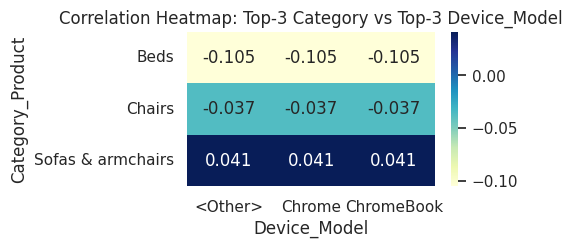

In [ ]:
top3_categories = category_total_sales.head(3).index

# Кореляція продажів за топ-3 категоріями товарів
category_daily_wide = price_clean[price_clean["Category_Product"].isin(top3_categories)]

category_daily_wide = category_daily_wide.pivot_table(index="Order_date", columns="Category_Product", values="Price", aggfunc="sum").fillna(0)

# Кореляція продажів за моделю девайсів
device_model_daily = price_clean.groupby(["Order_date","Device_Model"])["Price"].sum().reset_index()

device_model_daily_top3 = device_model_daily.head(3)

device_model_daily_wide = device_model_daily_top3.pivot_table(index="Order_date", columns="Device_Model", values="Price", aggfunc="sum").fillna(0)

# Об'єднуємо по даті
combined_daily_3 = category_daily_wide.join(device_model_daily_wide, how="outer").fillna(0)

# Кореляційна матриця
corr_combined = combined_daily_3.corr()

# Парні кореляції з p-value
results = []
for category in category_daily_wide:
    for model in device_model_daily_wide.columns:
        pearson_corr, pearson_p = pearsonr(combined_daily_3[category], combined_daily_3[model])
        spearman_corr, spearman_p = spearmanr(combined_daily_3[category], combined_daily_3[model])
        results.append({
            "Category_Product": category,
            "Device_Model": model,
            "Pearson Corr": round(pearson_corr,3),
            "Pearson p": round(pearson_p,3),
            "Spearman Corr": round(spearman_corr,3),
            "Spearman p": round(spearman_p,3)
        })

corr_table = pd.DataFrame(results)
display(corr_table)

# Heatmap товар (рядки) × моделы девайсів (стовпці)
heatmap_data = corr_table.pivot(index="Category_Product", columns="Device_Model", values="Pearson Corr")

plt.figure(figsize=(4,2))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Correlation Heatmap: Top-3 Category vs Top-3 Device_Model")
plt.show()

## Результати:
- Найсильніші позитивні кореляції між категоріями продуктів (топ-3) і моделю девайсів топ-3) спостерігаються для Sofas & armchairs (по всім моделям, єдину слабку позитивну кореляцію): Pearson 0,041, Spearman 0,091.
- Слабка негативна кореляція продемонстрована між категорією Beds і всіма пристроями (Pearson -0,105, Spearman -0,167)
- Категорія Chairs має зв'язок, близький до нуля (Pearson -0,037, Spearman -0,032).

Статистична значущість: повна відсутність статистичної значущості для всіх виявлених кореляцій, оскільки всі p > 0.05.

Основне: зв'язки є дуже слабкими

,AOV,Device,Pearson Corr,Pearson p,Spearman Corr,Spearman p
0,Canada,desktop,0.182,0.090,0.162,0.133
1,Canada,mobile,0.122,0.258,0.026,0.811
2,Canada,tablet,-0.017,0.875,0.031,0.775
3,India,desktop,0.130,0.227,0.257,0.016
4,India,mobile,0.093,0.390,0.144,0.180
5,India,tablet,-0.205,0.055,-0.141,0.189
6,United States,desktop,0.253,0.017,0.223,0.037
7,United States,mobile,0.268,0.012,0.274,0.010
8,United States,tablet,0.073,0.499,0.198,0.064


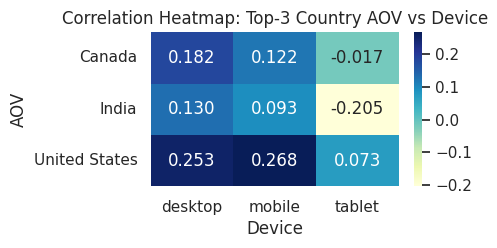

In [ ]:
# Кореляція середнього чеку (AOV) по топ-3 країнам та продажами девайсів

top3_countries = country_sales.head(3).index

country_daily = price_clean[price_clean["Country"].isin(top3_countries)]

daily_orders = country_daily.groupby(["Order_date", "Country"])["Price"].agg(['sum','count']).reset_index()

daily_orders["AOV"] = daily_orders["sum"] / daily_orders["count"]

aov_daily_wide = daily_orders.pivot(index="Order_date", columns="Country", values="AOV").fillna(0)

# Об'єднуємо по даті
combined_daily_4 = aov_daily_wide .join(device_daily_wide, how="outer").fillna(0)

# Кореляційна матриця
corr_combined = combined_daily_4.corr()

# Парні кореляції з p-value
results = []
for aov in aov_daily_wide :
    for device in device_daily_wide.columns:
        pearson_corr, pearson_p = pearsonr(combined_daily_4[aov], combined_daily_4[device])
        spearman_corr, spearman_p = spearmanr(combined_daily_4[aov], combined_daily_4[device])
        results.append({
            "AOV": aov,
            "Device": device,
            "Pearson Corr": round(pearson_corr,3),
            "Pearson p": round(pearson_p,3),
            "Spearman Corr": round(spearman_corr,3),
            "Spearman p": round(spearman_p,3)
        })

corr_table = pd.DataFrame(results)
display(corr_table)


# Heatmap крани (рядки) × моделы девайсів (стовпці)
heatmap_data = corr_table.pivot(index="AOV", columns="Device", values="Pearson Corr")

plt.figure(figsize=(4,2))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Correlation Heatmap: Top-3 Country AOV vs Device")
plt.show()

## Результати:
- Аналіз кореляції між Середнім Чеком (AOV) та типом пристрою (desktop, mobile, tablet) виявив помітні відмінності між трьома країнами.
- Сполучені Штати демонструють найсильніші позитивні зв'язки з mobile (Pearson 0,268, Spearman 0,274) та desktop (Pearson 0,253, Spearman 0,2223). Такі позитивні кореляції вказують на те, що у США AOV має тенденцію зростати разом зі збільшенням трафіку як з мобільних, так і з десктопних пристроїв.
- Канада також показує позитивну кореляцію для desktop (Pearson 0,182, Spearman 0,162) та mobile (Pearson 0,122, Spearman 0,026), хоча і помітно слабшу.
- Індія має помірну позитивну кореляцію з desktop (Pearson 0,130, Spearman 0,257), але, на відміну від інших країн, демонструє сильну негативну кореляцію з tablet (Pearson -0,205, Spearman -0,141), що є найнижчим показником у всьому аналізі.

Статистична значущість:
- Сполучені Штати є єдиною країною, де позитивні кореляції AOV з mobile та desktop є статистично значущими на рівні p < 0.05. Тобто, зв'язки між AOV та цими пристроями є стійкими і навряд чи виникли випадково.
- В Індії кореляція з desktop також є значущою за коефіцієнтом Спірмена, а негативний зв'язок із tablet знаходиться на межі значущості за коефіцієнтом Пірсона.
- У Канаді жодна з кореляцій не є статистично значущою (усі p > 0.05).

Основне:
- для підтримки AOV слід зосередитися на оптимізації трафіку та конверсії mobile та desktop, особливо на американському ринку.

# Статистичний аналіз відмінностей між групами

Traffic_Channel: Index(['Direct', 'Organic Search', 'Paid Search', 'Social Search'], dtype='object', name='Traffic_Channel')


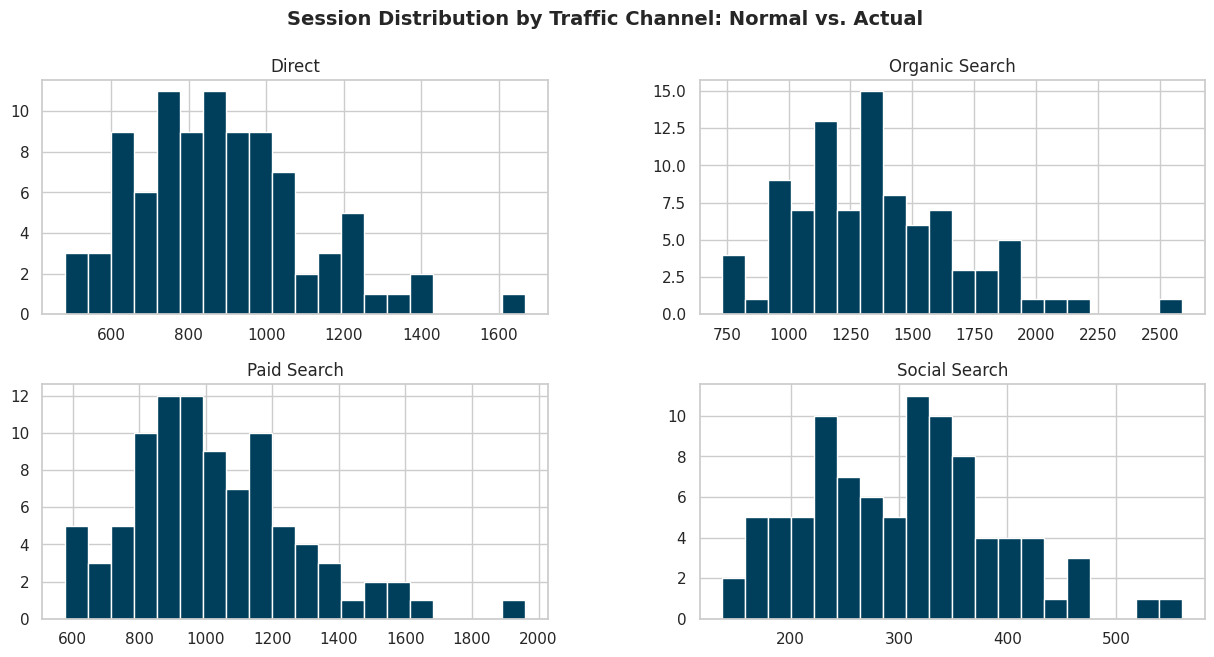

Shapiro-Wilk (нормальність):
Direct: stat=0.970, p=0.0343
 - Direct не нормальний розподіл
Organic Search: stat=0.964, p=0.0123
 - Organic Search не нормальний розподіл
Paid Search: stat=0.963, p=0.0108
 - Paid Search не нормальний розподіл
Social Search: stat=0.979, p=0.1413
 - Social Search можна вважати нормальним
Levene test: stat=23.463, p=0.0000
  - дисперсії між групами неоднорідні

Kruskal-Wallis: H=260.482, p=0.0000
  - середні ранги кількостей сесій різні між каналами


In [ ]:
from scipy.stats import shapiro, levene, kruskal
# Аналіз кількості сесій за різними каналами трафіку

# Сесії агреговано на денному рівні
channel_daily = sessions_clean.groupby(["Order_date","Traffic_Channel"])["Session_Id"].nunique().unstack(fill_value=0)

# Канали
channels = channel_daily.columns
print("Traffic_Channel:", channels)

channel_daily.hist(figsize=(15,7), bins=20, color="#003f5c")
plt.suptitle("Session Distribution by Traffic Channel: Normal vs. Actual", fontsize=14, fontweight="bold")
plt.show()

# Shapiro-Wilk для нормальності
print("Shapiro-Wilk (нормальність):")
normality_results = {}

for ch in channels:
    stat, p_value = shapiro(channel_daily[ch])
    normality_results[ch] = p_value
    print(f"{ch}: stat={stat:.3f}, p={p_value:.4f}")
    if p_value < 0.05:
        print(f" - {ch} не нормальний розподіл")
    else:
        print(f" - {ch} можна вважати нормальним")

# Levene для однорідності дисперсій
group_values = [channel_daily[ch].values for ch in channels]
stat, p_value = levene(*group_values)
print(f"Levene test: stat={stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("  - дисперсії між групами неоднорідні")
else:
    print("  - дисперсії між групами однорідні")

# Kruskal-Wallis (непараметричний аналог ANOVA)
kruskal_stat, kruskal_p = kruskal(*group_values)
print(f"\nKruskal-Wallis: H={kruskal_stat:.3f}, p={kruskal_p:.4f}")
if kruskal_p < 0.05:
    print("  - середні ранги кількостей сесій різні між каналами")
else:
    print("  - статистично значущих відмінностей немає")

## Гістограма кількості сесій по каналах показує нам наступні дані:
- Direct: розподіл сесій дещо асиметричний, з піком приблизно 800–1000 сесій на день.
- Organic Search: розподіл зміщений вправо, є кілька днів із дуже високою кількістю сесій (викиди).
- Paid Search: подібно до Direct, але з меншою кількістю пікованих днів і теж викиди.
- Social Search: розподіл більш компактний, приблизно нормальний, без сильних викидів.
Тобто, візуально можна помітити, що канали сильно різняться за середньою кількістю сесій.

## Провівши необхідні тести, можна сказати, що:
- Більшість каналів не мають нормального розподілу (за Шапіро-Уїлка), крім Social Search.
- Тест на гомогенність дисперсій показав, що класичний ANOVA може бути ненадійним, бо воно передбачає приблизно рівні дисперсії.
- Непараметричний тест Kruskal-Wallis підтвердив статистично значущу різницю між каналами.

In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

# Кількість унікальних сесій за регіоном
total_eur = sessions_clean[sessions_clean["Continent"]=="Europe"]["Session_Id"].nunique()
total_amer = sessions_clean[sessions_clean['Continent']=="Americas"]["Session_Id"].nunique()

# Кількість органічних сесій за регіоном
organic_eur = sessions_clean[(sessions_clean["Continent"]=="Europe") &
                              (sessions_clean["Traffic_Channel"]=="Organic Search")]["Session_Id"].nunique()
organic_amer = sessions_clean[(sessions_clean["Continent"]=="Americas") &
                               (sessions_clean["Traffic_Channel"]=="Organic Search")]["Session_Id"].nunique()

# Доля органічних сесій у %
organic_eur_percent = organic_eur / total_eur * 100
organic_amer_percent = organic_amer / total_amer * 100

# Різниця долей
delta_p = organic_eur_percent - organic_amer_percent

print(f"Europe percent organic sessions: {organic_eur_percent:.2f}%")
print(f"Americas percent organic sessions: {organic_amer_percent:.2f}%")
print(f"Difference Δp: {delta_p:.2f}%")

# 2x2 таблиця [organic, non-organic]
counts = np.array([[organic_eur, total_eur - organic_eur],
                   [organic_amer, total_amer - organic_amer]])
print("2x2 таблиця для тесту:")
print(counts)

# Z-test для двох пропорцій
stat, pval = proportions_ztest([organic_eur, organic_amer], [total_eur, total_amer])
print(f"Z-test: stat={stat:.3f}, p={pval:.3f}")

# Хі-квадрат тест
chi2, chi2_p, dof, expected = chi2_contingency(counts)
print(f"Chi-square test: chi2={chi2:.3f}, p={chi2_p:.3f}")

Europe percent organic sessions: 37.92%
Americas percent organic sessions: 37.90%
Difference Δp: 0.02%
2x2 таблиця для тесту:
[[ 23195  37973]
 [ 68671 112542]]
Z-test: stat=0.110, p=0.912
Chi-square test: chi2=0.011, p=0.916


## Усі тести показують p > 0.05, тобто немає статистично значущої різниці у долі органічних сесій між Європою та Америці. Обидва регіони мають майже однакову частку органічного трафіку (≈37,9%).

In [ ]:
# Збереження в CSV
data.to_csv("bigquery_data_for_tableau.csv", index=False)

from google.colab import files
files.download("bigquery_data_for_tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tableu: https://public.tableau.com/app/profile/zoya.ashmarina/viz/GeographicProductSalesAnalysis/GeographicProductSalesAnalysis